# Retrieval chatbot for initial twitter query

This project is a retrieval-based dialog system. It is a model that classifies whether response is the correct response to a given question/comment or not. Ideally, it retrieves the best response to a conversational input from a pool of responses.

This uses PyTorch LSTM with encoder and dual encoder.

**Data:**    

The data utilised for this project is the Customer Support on Twitter dataset, found through the following link: https://www.kaggle.com/thoughtvector/customer-support-on-twitter

It contains the following attributes:
+ tweet_id - unique, anonymised ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.
+ author_id - unique, anonymised user ID. @s in the dataset have been replaced with their associated anonymized user ID.
+ inbound - whether the tweet is "inbound" to a company doing customer support on Twitter. 
+ created_at = date and time when the tweet was sent.
+ text = tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.
+ response_tweet_id - IDs of tweets that are responses to this tweet, comma-separated.
+ in_response_to_tweet_id - ID of the tweet this tweet is in response to, if any.

This project will involve only the initial comment/question and response (approximately 66% of the full dataset). 

Firstly, the initial comment/question will be matched to the response from the company it is addressing. The questions texts will be processed, including the following:
+ remove handles
+ convert all to lowercase 
+ remove punctuation
+ remove stopwords
+ lemmatise
+ remove emojis and emoticons
+ remove urls
+ remove html
+ convert chat word language

For the response texts, as it is a retrieval model, the purpose is to reproduce the response that is evaluated as most appropriate given the initial comment. Therefore, as much of the structure will be retained. Handles, urls and html will be removed to make it a more general response.

Spellchecker was initially included - and would be for any model to be used in the real world - but took too long for purposes here.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import numpy as np
import re
import nltk
import spacy
import string

## Load the data and filter

In [2]:
df = pd.read_csv('data/twcs.csv')
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [3]:
#create inbound df that have responses
inbound = df[pd.isnull(df.in_response_to_tweet_id) & df.inbound]
print('There are {} initial inbound messages.'.format(len(inbound)))

# Merge in all tweets in response
inbounds_and_outbounds = pd.merge(inbound, df, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')
print("There are {} responses.".format(len(inbounds_and_outbounds)))

#filter out replies not from company
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

print("There are {} responses from companies.".format(len(inbounds_and_outbounds)))
print("Tweets Preview:")
for i in range(5):
    print('Comment:', inbounds_and_outbounds.text_x[i])
    print('Response:', inbounds_and_outbounds.text_y[i])
    print('-'*20)

There are 787346 initial inbound messages.
There are 875292 responses.
There are 794299 responses from companies.
Tweets Preview:
Comment: @sprintcare is the worst customer service
Response: @115712 Can you please send us a private message, so that I can gain further details about your account?
--------------------
Comment: @sprintcare is the worst customer service
Response: @115712 I would love the chance to review the account and provide assistance.
--------------------
Comment: @sprintcare is the worst customer service
Response: @115712 Hello! We never like our customers to feel like they are not valued.
--------------------
Comment: @115714 y’all lie about your “great” connection. 5 bars LTE, still won’t load something. Smh.
Response: @115713 H there! We'd definitely like to work with you on this, how long have you been experiencing this issue? -AA
--------------------
Comment: @115714 whenever I contact customer support, they tell me I have shortcode enabled on my account, but I h

In [4]:
data = inbounds_and_outbounds[['author_id_x','text_x','text_y','author_id_y']]
data = data.rename(columns = {"text_x": "question",
                              "text_y":"response"}) 

In [5]:
data.head()

,author_id_x,question,response,author_id_y
0,115712,@sprintcare is the worst customer service,@115712 Can you please send us a private messa...,sprintcare
1,115712,@sprintcare is the worst customer service,@115712 I would love the chance to review the ...,sprintcare
2,115712,@sprintcare is the worst customer service,@115712 Hello! We never like our customers to ...,sprintcare
3,115713,@115714 y’all lie about your “great” connectio...,@115713 H there! We'd definitely like to work ...,sprintcare
4,115715,"@115714 whenever I contact customer support, t...",@115715 Please send me a private message so th...,sprintcare


## Preprocess text

In [6]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """function to remove punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """function to remove stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [7]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [8]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)


def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


from bs4 import BeautifulSoup
def remove_html(text):
    return BeautifulSoup(text, "lxml").text

In [9]:
chat_words_str=["AFAIK=As Far As I Know","AFK=Away From Keyboard","ASAP=As Soon As Possible","ATK=At The Keyboard",
                "ATM=At The Moment","A3=Anytime, Anywhere, Anyplace","BAK=Back At Keyboard","BBL=Be Back Later","BBS=Be Back Soon","BFN=Bye For Now",
                "B4N=Bye For Now","BRB=Be Right Back","BRT=Be Right There","BTW=By The Way,B4=Before","B4N=Bye For Now",
                "CU=See You","CUL8R=See You Later","CYA=See You","FAQ=Frequently Asked Questions","FC=Fingers Crossed","FWIW=For What It's Worth",
                "FYI=For Your Information","GAL=Get A Life","GG=Good Game","GN=Good Night","GMTA=Great Minds Think Alike",
                "GR8=Great!","G9=Genius","IC=I See","ICQ=I Seek you","ILU=I Love You","IMHO=In My Honest/Humble Opinion",
                "IMO=In My Opinion","IOW=In Other Words","IRL=In Real Life","KISS=Keep It Simple", "Stupid,LDR=Long Distance Relationship",
                "LMAO=Laugh My A.. Off","LOL=Laughing Out Loud","LTNS=Long Time No See","L8R=Later","MTE=My Thoughts Exactly","M8=Mate","NRN=No Reply Necessary",
                "OIC=Oh I See","PITA=Pain In The A..","PRT=Party","PRW=Parents Are Watching","QPSA?=Que Pasa?","ROFL=Rolling On The Floor Laughing",
                "ROFLOL=Rolling On The Floor Laughing Out Loud","ROTFLMAO=Rolling On The Floor Laughing My A.. Off","SK8=Skate",
                "STATS=Your sex and age","ASL=Age, Sex, Location","THX=Thank You","TTFN=Ta-Ta For Now!","TTYL=Talk To You Later","U=You",
                "U2=You Too","U4E=Yours For Ever","WB=Welcome Back","WTF=What The F...","WTG=Way To Go!","WUF=Where Are You From?","W8=Wait..."]

In [10]:
chat_words_map_dict = {}
chat_words_list = []
for i in chat_words_str:
    cw = i.split("=")[0]
    cw_expanded = i.split("=")[1]
    chat_words_list.append(cw)
    chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [11]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [12]:
#this would be applied to all new user input before applying the model to predict a response
def process_text(data, col):
    data[col] = data[col].astype(str)
    
    #remove handles
    data[col] = data[col].apply(lambda x : ' '.join([w.lower() for w in x.split() if not w.startswith(('@','.@','".@','"@','http')) ]))
    print('Removal of handles completed')
    #lowercase
    data[col] = data[col].str.lower()
    
    data[col] = data[col].apply(lambda text: remove_punctuation(text))
    print('Removal of punctuation completed')
    data[col] = data[col].apply(lambda text: remove_stopwords(text))
    print('Removal of stopwords completed')

    data[col] = data[col].apply(lambda text: lemmatize_words(text))
    print('Lemmatization completed')

    data[col] = data[col].apply(lambda text: remove_emoji(text))
    data[col] = data[col].apply(lambda text: remove_emoticons(text))
    print('Removal of emoticons and emojis completed')
    
    data[col] = data[col].apply(lambda text: remove_urls(text))
    data[col] = data[col].apply(lambda text: remove_html(text))
    print('Removal of urls and html completed')
    
    data[col] = data[col].apply(lambda text: chat_words_conversion(text))
    print('Chat word conversion completed')

    #spell checking commented out as ran too long 
    #data[col] = data[col].apply(lambda text: correct_spellings(text))
    #print('Spelling corrections completed')
    print('Text processing for {} text completed'.format(col))
    
    return data

In [13]:
data = process_text(data, 'question')

Removal of handles completed
Removal of punctuation completed
Removal of stopwords completed
Lemmatization completed
Removal of emoticons and emojis completed
Removal of urls and html completed
Chat word conversion completed
Text processing for question text completed


For responses, these will be kept relatively raw as the purpose of the chatbot will be to retrieve the most relevant response and output it to the user, therefore we want it to remain as a sentence.

Handles will be removed so responses are more general (not targetd at a specific user. If we are seeking to create a chatbot for the purpose of responding to tweets, the handle of the user that created the question would be selected from the dataframe and a rule put in place to generate the handle at the start of the response.

In [14]:
#remove handles, urls and htmls from responses
data['response'] = data['response'].apply(lambda x : ' '.join([w.lower() for w in x.split() if not w.startswith(('@','.@','".@','"@','http')) ]))
data['response'] = data['response'].apply(lambda text: remove_urls(text))
data['response'] = data['response'].apply(lambda text: remove_html(text))

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [15]:
data.head()

,author_id_x,question,response,author_id_y
0,115712,worst customer service,"can you please send us a private message, so t...",sprintcare
1,115712,worst customer service,i would love the chance to review the account ...,sprintcare
2,115712,worst customer service,hello! we never like our customers to feel lik...,sprintcare
3,115713,y’all lie “great” connection 5 bar lte still w...,h there! we'd definitely like to work with you...,sprintcare
4,115715,whenever contact customer support tell shortco...,please send me a private message so that i can...,sprintcare


In [16]:
#save processed data
data.to_pickle("processed_data.pkl")

## Prepare data for model

### Creating false responses for questions

In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.autograd as autograd
from torch.nn import init
import torch.nn.utils.rnn 
import datetime
import operator

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

np.random.seed(0)

In [2]:
data = pd.read_pickle("processed_data.pkl")

In [3]:
#create false examples
def shuffle_dataframe(dataframe):
    return dataframe.reindex(np.random.permutation(dataframe.index))

In [4]:
#take sample of data 
data = shuffle_dataframe(data)
data_sample = data[:25000]
data_sample.shape

(25000, 4)

In [5]:
data_false = data_sample.copy(deep=True)

data_false_question = data_false[['author_id_x','question']]
data_false_response = data_false[['author_id_y','response']]

data_false_response = shuffle_dataframe(data_false_response)

data_false_question.reset_index(drop=True, inplace=True)
data_false_response.reset_index(drop=True, inplace=True)

df_false = pd.concat([data_false_question, data_false_response], axis=1)

df_false['label'] = 0

data_sample['label'] = 1

df = data_sample.append(df_false, ignore_index=True)

df = shuffle_dataframe(df)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(array([25000.,     0., 25000.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

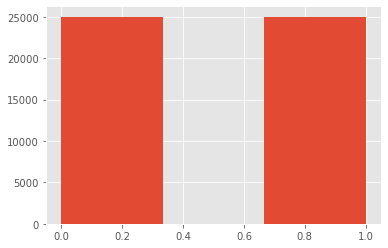

In [6]:
plt.hist(df['label'], bins=3)

In [7]:
df['label'].value_counts()

1    25000
0    25000
Name: label, dtype: int64

### Train-validation-test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
training_samp, test_samp = train_test_split(df, test_size=0.2, random_state=42)

training_samp, validation_samp = train_test_split(training_samp, test_size=0.2, random_state=42)

In [10]:
len(training_samp), len(validation_samp), len(test_samp)

(32000, 8000, 10000)

In [11]:
print('labels for training set:\n', training_samp['label'].value_counts())
print('labels for validation set:\n', validation_samp['label'].value_counts())
print('labels for test set:\n', test_samp['label'].value_counts())

labels for training set:
 1    16008
0    15992
Name: label, dtype: int64
labels for validation set:
 1    4005
0    3995
Name: label, dtype: int64
labels for test set:
 0    5013
1    4987
Name: label, dtype: int64


In [12]:
num_training_examples = len(training_samp)
num_validation_examples = len(validation_samp)

training_samp.to_csv("training_samp.csv")
validation_samp.to_csv("validation_samp.csv")
test_samp.to_csv("test_samp.csv")

### Helper fuctions to create variables for training, validation and testing

In [13]:
def create_dataframe(csvfile):
    dataframe = pd.read_csv(csvfile)
    return dataframe

def create_vocab(dataframe):
    vocab = []
    word_freq = {}
    
    for index, row in dataframe.iterrows():
        
        context_cell = row["question"]
        response_cell = row["response"]
        
        train_words = str(context_cell).split() + str(response_cell).split()
        
        for word in train_words:
          
            if word.lower() not in vocab:
                vocab.append(word.lower())         
                       
            if word.lower() not in word_freq:
                word_freq[word.lower()] = 1
            else:
                word_freq[word.lower()] += 1
    
    word_freq_sorted = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    vocab = ["<UNK>"] + [pair[0] for pair in word_freq_sorted]
    
    return vocab

def create_word_to_id(vocab):             
    word_to_id = {word: id for id, word in enumerate(vocab)}
    
    return word_to_id


def create_id_to_vec(word_to_id, glovefile): 
    lines = open(glovefile, 'r').readlines()
    id_to_vec = {}
    vector = None
    
    for line in lines:
        word = line.split()[0]
        vector = np.array(line.split()[1:], dtype='float32') 
        
        if word in word_to_id:
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(vector))
            
    for word, id in word_to_id.items(): 
        if word_to_id[word] not in id_to_vec:
            v = np.zeros(*vector.shape, dtype='float32')
            v[:] = np.random.randn(*v.shape)*0.01
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(v))
            
    embedding_dim = id_to_vec[0].shape[0]
    
    return id_to_vec, embedding_dim


def load_ids_and_labels(row, word_to_id):
    context_ids = []
    response_ids = []

    context_cell = row['question']
    response_cell = row['response']
    label_cell = row['label']

    max_context_len = 160
    
    context_words = str(context_cell).split()
    if len(context_words) > max_context_len:
        context_words = context_words[:max_context_len]
    for word in context_words:
        if word in word_to_id:
            context_ids.append(word_to_id[word])
        else: 
            context_ids.append(0) 
    
    response_words = str(response_cell).split()
    for word in response_words:
        if word in word_to_id:
            response_ids.append(word_to_id[word])
        else: 
            response_ids.append(0)
    
    label = np.array(label_cell).astype(np.float32)

    return context_ids, response_ids, label

## Building, training and validating the model

In [14]:
#define model classes
class Encoder(nn.Module):
    def __init__(self, 
            emb_size, 
            hidden_size, 
            vocab_size, 
            p_dropout): 
    
            super(Encoder, self).__init__()
             
            self.emb_size = emb_size
            self.hidden_size = hidden_size
            self.vocab_size = vocab_size
            self.p_dropout = p_dropout
       
            self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
            self.lstm = nn.LSTM(self.emb_size, self.hidden_size)
            self.dropout_layer = nn.Dropout(self.p_dropout) 

            self.init_weights()
             
    def init_weights(self):
        init.uniform_(self.lstm.weight_ih_l0, a = -0.01, b = 0.01)
        init.orthogonal_(self.lstm.weight_hh_l0)
        self.lstm.weight_ih_l0.requires_grad = True
        self.lstm.weight_hh_l0.requires_grad = True
        
        embedding_weights = torch.FloatTensor(self.vocab_size, self.emb_size)
            
        for id, vec in id_to_vec.items():
            embedding_weights[id] = vec
        
        self.embedding.weight = nn.Parameter(embedding_weights, requires_grad = True)
            
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        _, (last_hidden, _) = self.lstm(embeddings) #dimensions (num_layers * num_directions x batch_size x hidden_size)
        last_hidden = self.dropout_layer(last_hidden[-1]) #accesses last lstm layer, dimensions (batch_size x hidden_size)

        return last_hidden

    
class DualEncoder(nn.Module):    
    def __init__(self, encoder):
        super(DualEncoder, self).__init__()
        self.encoder = encoder
        self.hidden_size = self.encoder.hidden_size
        M = torch.FloatTensor(self.hidden_size, self.hidden_size)     
        init.xavier_normal_(M)
        self.M = nn.Parameter(M, requires_grad = True)

    def forward(self, context_tensor, response_tensor):
        
        context_last_hidden = self.encoder(context_tensor) #dimensions (batch_size x hidden_size)
        response_last_hidden = self.encoder(response_tensor) #dimensions (batch_size x hidden_size)
        
        context = context_last_hidden.mm(self.M) #dimensions (batch_size x hidden_size)
        context = context.view(-1, 1, self.hidden_size) #dimensions (batch_size x 1 x hidden_size)
        
        response = response_last_hidden.view(-1, self.hidden_size, 1) #dimensions (batch_size x hidden_size x 1)
        
        score = torch.bmm(context, response).view(-1, 1) #dimensions (batch_size x 1 x 1) and (batch_size x 1)

        return score

In [15]:
#function to call helper functions with number of examples and embedding dimension (GloVe embedding vectors used here)
def creating_variables(embedding_dim):

    print(str(datetime.datetime.now()).split('.')[0], "Creating variables for training and validation...")

    training_dataframe = create_dataframe('training_samp.csv')
    vocab = create_vocab(training_dataframe)
    word_to_id = create_word_to_id(vocab)
    id_to_vec, emb_dim = create_id_to_vec(word_to_id, 'glove.6B/glove.6B.%dd.txt' %embedding_dim)

    validation_dataframe = create_dataframe('validation_samp.csv')

    print(str(datetime.datetime.now()).split('.')[0], "Variables created.\n")
    
    return training_dataframe, vocab, word_to_id, id_to_vec, emb_dim, validation_dataframe

In [16]:
#function to create model instance with desired hyperparameters (only vary hidden_size and p_dropout)
def creating_model(hidden_size, p_dropout):

    print(str(datetime.datetime.now()).split('.')[0], "Calling model...")

    encoder = Encoder(
            emb_size = emb_dim,
            hidden_size = hidden_size,
            vocab_size = len(vocab),
            p_dropout = p_dropout)

    dual_encoder = DualEncoder(encoder)

    print(str(datetime.datetime.now()).split('.')[0], "Model created.\n")
    print(dual_encoder)
    
    return encoder, dual_encoder

In [17]:
#additional helper functions
def increase_count(correct_count, score, label):
    if ((score.data[0][0] >= 0.5) and (label.data[0][0] == 1.0)) or ((score.data[0][0] < 0.5) and (label.data[0][0]  == 0.0)):
        correct_count +=1  
   
    return correct_count

def get_accuracy(correct_count, dataframe):
    accuracy = correct_count/(len(dataframe))
        
    return accuracy

In [18]:
#function defining training and validation method
def train_model(learning_rate, l2_penalty, epochs): 
    print(str(datetime.datetime.now()).split('.')[0], "Commencing training and validation...\n")
    print("Data and Hyperparameter Overview:\n")
    print("Number of training examples: {0}, Number of validation examples: {1}".format(len(training_dataframe), len(validation_dataframe)))
    print("Learning rate: {0}, Embedding Dimension: {1}, Hidden Size: {2}, Dropout: {3}, L2:{4}\n".format(learning_rate, emb_dim, encoder.hidden_size, encoder.p_dropout, l2_penalty))
    print("Results:\n")

    optimizer = torch.optim.Adam(dual_encoder.parameters(), lr = learning_rate, weight_decay = l2_penalty)
    loss_func = torch.nn.BCEWithLogitsLoss()
    best_validation_accuracy = 0.0
     
    for epoch in range(epochs): 
                     
            shuffle_dataframe(training_dataframe)
            sum_loss_training = 0.0
            training_correct_count = 0
            dual_encoder.train()

            for index, row in training_dataframe.iterrows():            
            
                context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
                context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1), requires_grad = False) 
                response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1), requires_grad = False) 
                label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1))), requires_grad = False) 
                             
                score = dual_encoder(context, response)
                loss = loss_func(score, label)
                #sum_loss_training += loss.data[0]
                sum_loss_training += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                training_correct_count = increase_count(training_correct_count, score, label)
                                                    
            training_accuracy = get_accuracy(training_correct_count, training_dataframe)
                
            shuffle_dataframe(validation_dataframe)
            
            validation_correct_count = 0
            sum_loss_validation = 0.0
            dual_encoder.eval()

            for index, row in validation_dataframe.iterrows():
                
                context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
                context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)) 
                response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)) 
                label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1)))) 
                
                score = dual_encoder(context, response)
                loss = loss_func(score, label)
                sum_loss_validation += loss.item()
                validation_correct_count = increase_count(validation_correct_count, score, label)
                    
            validation_accuracy = get_accuracy(validation_correct_count, validation_dataframe)
                        
            print(str(datetime.datetime.now()).split('.')[0], 
                  "Epoch: {0}/{1}".format(epoch,epochs),  
                  "TrainLoss: {0}".format(sum_loss_training/len(training_dataframe)), 
                  "TrainAccuracy: {0}".format(training_accuracy), 
                  "ValLoss: {0}".format(sum_loss_validation/len(validation_dataframe)), 
                  "ValAccuracy: {0}".format(validation_accuracy))
            
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                torch.save(dual_encoder.state_dict(), 'saved_model_samp.pt')
                print("New best found and saved.")
                
    print(str(datetime.datetime.now()).split('.')[0], "Training and validation epochs finished.")

In [19]:
#define embedding dimension (for glove embedding), create variables for training and validation
training_dataframe, vocab, word_to_id, id_to_vec, emb_dim, validation_dataframe = creating_variables(embedding_dim = 300)

2020-02-05 09:00:33 Creating variables for training and validation...
2020-02-05 09:01:39 Variables created.



In [20]:
#define hidden size and dropout probability, creating model
encoder, dual_encoder = creating_model(hidden_size = 100, 
                                       p_dropout = 0.85)

for name, param in dual_encoder.named_parameters():
    if param.requires_grad:
        print(name)

2020-02-05 09:01:39 Calling model...
2020-02-05 09:01:39 Model created.

DualEncoder(
  (encoder): Encoder(
    (embedding): Embedding(43667, 300)
    (lstm): LSTM(300, 100)
    (dropout_layer): Dropout(p=0.85, inplace=False)
  )
)
M
encoder.embedding.weight
encoder.lstm.weight_ih_l0
encoder.lstm.weight_hh_l0
encoder.lstm.bias_ih_l0
encoder.lstm.bias_hh_l0


In [21]:
#choose learning rate and number of epochs, start training and validation epochs
train_model(learning_rate = 0.01, 
            l2_penalty = 0.0001,
            epochs = 10)

2020-02-05 09:01:39 Commencing training and validation...

Data and Hyperparameter Overview:

Number of training examples: 32000, Number of validation examples: 8000
Learning rate: 0.01, Embedding Dimension: 300, Hidden Size: 100, Dropout: 0.85, L2:0.0001

Results:

2020-02-05 11:52:56 Epoch: 0/10 TrainLoss: 2.1231754573071098 TrainAccuracy: 0.50171875 ValLoss: 0.8747915415583399 ValAccuracy: 0.50025
New best found and saved.
2020-02-05 14:40:12 Epoch: 1/10 TrainLoss: 1.149710510901465 TrainAccuracy: 0.50021875 ValLoss: 0.7001029913139064 ValAccuracy: 0.50075
New best found and saved.
2020-02-05 19:32:41 Epoch: 2/10 TrainLoss: 1.0215891242468764 TrainAccuracy: 0.50096875 ValLoss: 0.7056017472544918 ValAccuracy: 0.500625
2020-02-05 22:05:04 Epoch: 3/10 TrainLoss: 1.1513734656316552 TrainAccuracy: 0.5030625 ValLoss: 0.7712304085881333 ValAccuracy: 0.50025
2020-02-06 00:37:30 Epoch: 4/10 TrainLoss: 1.178643086723236 TrainAccuracy: 0.49896875 ValLoss: 0.7062790361363441 ValAccuracy: 0.5001

In [22]:
#load saved model
dual_encoder.load_state_dict(torch.load('saved_model_samp.pt'))

dual_encoder.eval()

DualEncoder(
  (encoder): Encoder(
    (embedding): Embedding(43667, 300)
    (lstm): LSTM(300, 100)
    (dropout_layer): Dropout(p=0.85, inplace=False)
  )
)

## Testing model performance on prediction (accuracy)

In [24]:
test_dataframe = pd.read_csv('test_samp.csv')

In [25]:
def testing():
    
    test_correct_count = 0

    for index, row in test_dataframe.iterrows():

        context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
        context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)) 
        response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)) 
        label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1)))) 

        score = dual_encoder(context, response)
        test_correct_count = increase_count(test_correct_count, score, label)

    test_accuracy = get_accuracy(test_correct_count, test_dataframe)
    
    return test_accuracy

In [28]:
test_accuracy = testing()
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.4999


## Using the model to generate a response

In [41]:
def load_response_ids(row, word_to_id):
    response_ids = []

    response_cell = row['response']
    
    response_words = str(response_cell).split()
    for word in response_words:
        if word in word_to_id:
            response_ids.append(word_to_id[word])
        else: 
            response_ids.append(0)
    
    return response_ids

In [42]:
def load_context_ids(context_cell, word_to_id):
    context_ids = []
    
    #context_cell = df['question'][row]
    max_context_len = 160

    context_words = str(context_cell).split()
    if len(context_words) > max_context_len:
        context_words = context_words[:max_context_len]
    for word in context_words:
        if word in word_to_id:
             context_ids.append(word_to_id[word])
        else: 
            context_ids.append(0) 
    return context_ids

In [43]:
#make copy of test and reindex, select context, then shuffle and reindex
test_dataframe_copy = test_dataframe.copy(deep=True)

row = 0
context_cell = test_dataframe_copy['question'][row]
context_ids = load_context_ids(context_cell, word_to_id)

#shuffle and reindex to avoid concerns over response selection based on matching index of question-response
test_dataframe_copy = shuffle_dataframe(test_dataframe_copy)
test_dataframe_copy.reset_index(drop=True, inplace=True)

print(context_cell)
scores = {}
for index, row in test_dataframe_copy.iterrows():

    response_ids = load_response_ids(row, word_to_id)
    context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)) 
    response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)) 

    score = dual_encoder(context, response)
    scores[index] = score

since oct 18 run stop sync know anything


In [60]:
#find index with max score from scores dictionary
row = 0
keymax = max(scores, key=scores.get) 
best_response = test_dataframe_copy['response'][keymax]
print('@'+str(test_dataframe.iloc[row,1]) + ' ' + best_response)

@166750 hello there. are you getting any error code or message? please provide us more details about the issue


Despite the low accuracy, the response given to the selected test question appears to make sense.

The accruacy achieved for train, validation and test sets are all relatively low (though similar, indicating no overfitting). To achieve a higher accuracy, more data is required. However, on this current machine, when attempts were made to use the entire dataset, a single epoch was taking days so that attempt was abandoned.

For real-world purposes, and for a single business, a large set of input questions received from customers along with standard responses that the company would want to provide to its customers would be used to train the model, and these responses would be provided to the chatbot in responding to their customers' queries as above - the query processed, and then the best response retrieved from the set of acceptable responses provided by the company.